匯入套件

In [1]:
import tensorflow as tf
import   keras 
from   keras.datasets   import   cifar10 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications   import   VGG19 
from keras.layers import Input

引用VGG19模型到model的變數，使用已訓練好的權重


In [2]:
vgg19_model = VGG19(include_top = True, weights='imagenet')

vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

複製VGG19層數,凍結VGG19的神經層，因為VGG19神經層已被ImageNet資料集訓練過，保留特徵 
新增Dropout防止overfitting
增添新的
，作為 cifar10 的10類分類器

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

#新增model
model = Sequential()

#新增VGG19model參數
for layer in vgg19_model.layers[:-1]:
  model.add(layer)
  
#凍結VGG19的神經層
for layer in model.layers:
  layer.trainable = False
  
#新增Dropout
model.add(Dropout(0.5))
#新增密集層
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

載入cifar10資料庫

In [4]:
(x_train, y_train) , (x_val, y_val) = cifar10.load_data()

引入資料預處理的套件

In [5]:


import numpy as np
import cv2



one-hot 標籤

In [6]:


import matplotlib.pyplot as plt

NUM_CLASSES = 10


y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)



採取隨機取樣放大的原因，如果將圖片訓練集都放大放入訓練當中，RAM和顯存使用率無法負荷，所以採取分批放大我們的圖像

In [7]:
#新增getBatch函數(生成數量,取得訓練集、驗證集)
def getBatch(batch_size, train_or_val='train'):
#新建放大224x224的list
  x_batch = []
  y_batch = []
  if train_or_val == 'train':
    #隨機新增訓練集的數量
    idx = np.random.randint(0, len(x_train), (batch_size))
    #放大訓練集裡的圖片
    for i in idx:
      img = cv2.resize(x_train[i], (224, 224), interpolation=cv2.INTER_CUBIC)
      x_batch.append(img)
      y_batch.append(y_train[i])
  elif train_or_val == 'val':
     #隨機新增驗證集的數量
    idx = np.random.randint(0, len(x_val), (batch_size))
    #放大驗證集裡的圖片
    for i in idx:
      img = cv2.resize(x_val[i], (224, 224), interpolation=cv2.INTER_CUBIC)
      x_batch.append(img)
      y_batch.append(y_val[i]) 
  else:
    print("error, please specify train or val")
    #放入array
  x_batch = np.array(x_batch)
  y_batch = np.array(y_batch)
  return x_batch, y_batch
    



In [8]:
#compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

使用.train_on_batch不使用.fit()的原因在於
fit()以固定的數量去做訓練，可是在電腦資源有限的情況很難去執行

In [9]:
#ECHO數
EPOCHS = 20
#取張量數量
BATCH_SIZE = 50
#取訓練集數量
VAL_SIZE = 500
#做訓練集的次數
STEPS = 50


for e in range(EPOCHS):
  train_loss = 0
  train_acc = 0

  for s in range(STEPS):
    x_batch, y_batch = getBatch(BATCH_SIZE, "train")
    #单次梯度更新
    out = model.train_on_batch(x_batch, y_batch)
    #return[0]是訓練的損失函數
    train_loss += out[0]
    #return[0]是訓練的損失函數
    train_acc += out[1]
  
  print(f"Epoch: {e}\nTraining Loss = {train_loss / STEPS}\tTraining Acc = {train_acc / STEPS}")
  
  x_v, y_v = getBatch(VAL_SIZE, "val")
    #返回誤差值和評估標準值。
  eval = model.evaluate(x_v, y_v)
  print(f"Validation loss: {eval[0]}\tValidation Acc: {eval[1]}\n")
  
  





Epoch: 0
Training Loss = 2.031689376831055	Training Acc = 0.4507999990135431
16/16 [==============================] - 10s 472ms/step - loss: 0.8568 - categorical_accuracy: 0.6920
Validation loss: 0.8567920923233032	Validation Acc: 0.6919999718666077

Epoch: 1
Training Loss = 1.223381953239441	Training Acc = 0.6460000026226044
16/16 [==============================] - 6s 344ms/step - loss: 0.8509 - categorical_accuracy: 0.7160
Validation loss: 0.850893497467041	Validation Acc: 0.7160000205039978

Epoch: 2
Training Loss = 1.1749324703216553	Training Acc = 0.6664000034332276
16/16 [==============================] - 5s 342ms/step - loss: 0.9742 - categorical_accuracy: 0.7020
Validation loss: 0.9741791486740112	Validation Acc: 0.7020000219345093

Epoch: 3
Training Loss = 1.1160277926921844	Training Acc = 0.672800006866455
16/16 [==============================] - 5s 342ms/step - loss: 0.8631 - categorical_accuracy: 0.7320
Validation loss: 0.8631477952003479	Validation Acc: 0.7319999933242798


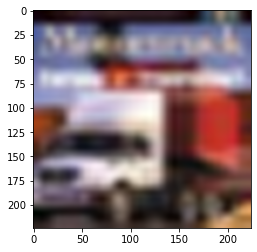

pred: ship
acct: truck


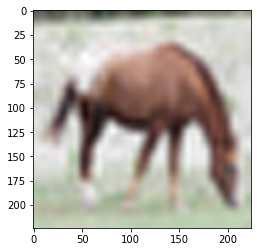

pred: horse
acct: horse


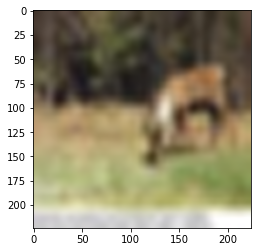

pred: deer
acct: deer


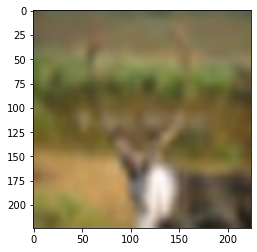

pred: deer
acct: deer


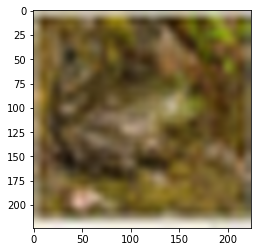

pred: frog
acct: frog


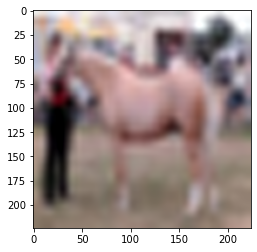

pred: horse
acct: horse


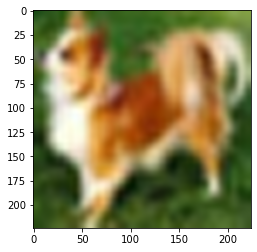

pred: frog
acct: dog


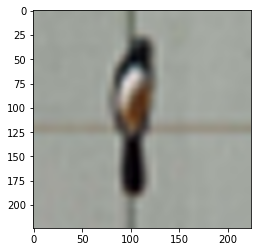

pred: bird
acct: bird


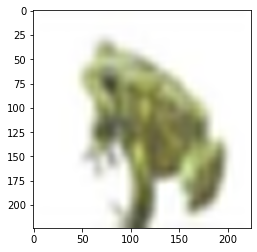

pred: frog
acct: frog


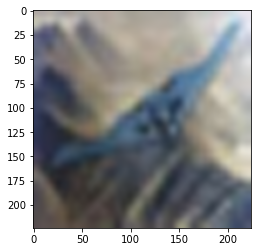

pred: airplane
acct: airplane


In [10]:
#辨識標籤
CATEGORIES = "airplane automobile bird cat deer dog frog horse ship truck".split(" ")

import matplotlib.pyplot as plt
#取10個隨機驗證集
x_v, y_v = getBatch(10, "val")

for i in range(10):

  import numpy as np
  plt.imshow(x_v[i])
  plt.show()
    #使用模型預測對10種分類做預測，取最高機率的位置，放在標籤的list
  print("pred: " +  CATEGORIES[np.argmax(model.predict(x_v[i:i+1]))])
  print("acct: " + CATEGORIES[np.argmax(y_v[i])])


 

